In [1]:
import datetime as dt
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import pandas_profiling as pdp
import seaborn as sns
import xgboost as xgb
import gc
from sklearn.preprocessing import LabelEncoder

# 交差検証
from sklearn.model_selection import TimeSeriesSplit,KFold

# モデルの評価指標
from sklearn.metrics import roc_auc_score

pd.set_option('display.max_columns', 400)
pd.set_option('display.max_rows', 500)

plt.style.use('ggplot') 
font = {'family' : 'meiryo'}
matplotlib.rc('font', **font)

In [2]:
train_id = pd.read_csv('../data/input/train_identity.csv.zip')
train_trans = pd.read_csv('../data/input/train_transaction.csv.zip')

test_id = pd.read_csv('../data/input/test_identity.csv.zip')
test_trans = pd.read_csv('../data/input/test_transaction.csv.zip')

sample_submission = pd.read_csv('../data/input/sample_submission.csv.zip', index_col='TransactionID')

In [3]:
train_id.head()

,TransactionID,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987004,0.0,70787.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.0,NotFound,NaN,-480.0,New,NotFound,166.0,NaN,542.0,144.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,Android 7.0,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M
1,2987008,-5.0,98945.0,NaN,NaN,0.0,-5.0,NaN,NaN,NaN,NaN,100.0,NotFound,49.0,-300.0,New,NotFound,166.0,NaN,621.0,500.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,iOS 11.1.2,mobile safari 11.0,32.0,1334x750,match_status:1,T,F,F,T,mobile,iOS Device
2,2987010,-5.0,191631.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,100.0,NotFound,52.0,NaN,Found,Found,121.0,NaN,410.0,142.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Found,Found,NaN,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,Windows
3,2987011,-5.0,221832.0,NaN,NaN,0.0,-6.0,NaN,NaN,NaN,NaN,100.0,NotFound,52.0,NaN,New,NotFound,225.0,NaN,176.0,507.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,NaN,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,NaN
4,2987016,0.0,7460.0,0.0,0.0,1.0,0.0,NaN,NaN,0.0,0.0,100.0,NotFound,NaN,-300.0,Found,Found,166.0,15.0,529.0,575.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Found,Found,Mac OS X 10_11_6,chrome 62.0,24.0,1280x800,match_status:2,T,F,T,T,desktop,MacOS


In [4]:
train_trans.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,M1,M2,M3,M4,M5,M6,M7,M8,M9,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,V46,V47,V48,V49,V50,V51,V52,V53,V54,V55,V56,V57,V58,V59,V60,V61,V62,V63,V64,V65,V66,V67,V68,V69,V70,V71,V72,V73,V74,V75,V76,V77,V78,V79,V80,V81,V82,V83,V84,V85,V86,V87,V88,V89,V90,V91,V92,V93,V94,V95,V96,V97,V98,V99,V100,V101,V102,V103,V104,V105,V106,V107,V108,V109,V110,V111,V112,V113,V114,V115,V116,V117,V118,V119,V120,V121,V122,V123,V124,V125,V126,V127,V128,V129,V130,V131,V132,V133,V134,V135,V136,V137,V138,V139,V140,V141,V142,V143,V144,V145,V146,V147,V148,V149,V150,V151,V152,V153,V154,V155,V156,V157,V158,V159,V160,V161,V162,V163,V164,V165,V166,V167,V168,V169,V170,V171,V172,V173,V174,V175,V176,V177,V178,V179,V180,V181,V182,V183,V184,V185,V186,V187,V188,V189,V190,V191,V192,V193,V194,V195,V196,V197,V198,V199,V200,V201,V202,V203,V204,V205,V206,V207,V208,V209,V210,V211,V212,V213,V214,V215,V216,V217,V218,V219,V220,V221,V222,V223,V224,V225,V226,V227,V228,V229,V230,V231,V232,V233,V234,V235,V236,V237,V238,V239,V240,V241,V242,V243,V244,V245,V246,V247,V248,V249,V250,V251,V252,V253,V254,V255,V256,V257,V258,V259,V260,V261,V262,V263,V264,V265,V266,V267,V268,V269,V270,V271,V272,V273,V274,V275,V276,V277,V278,V279,V280,V281,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,credit,315.0,87.0,19.0,NaN,NaN,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN,13.0,13.0,NaN,NaN,NaN,0.0,T,T,T,M2,F,T,NaN,NaN,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,credit,325.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,M0,T,T,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,

In [5]:
merged_train = train_trans.merge(train_id, how='left', left_index=True, right_index=True)
del train_trans, train_id

merged_test = test_trans.merge(test_id, how='left', left_index=True, right_index=True)
del test_trans, test_id

gc.collect

<function gc.collect(generation=2)>

In [6]:
def get_feat_names():
    for col in merged_train.columns:
        print('"'+col+'",')

# get_feat_names()

In [6]:
print(merged_train.shape)
print(merged_test.shape)

(590540, 435)
(506691, 434)


In [7]:
y_train = merged_train['isFraud'].copy()

X_train = merged_train.drop('isFraud', axis=1)
X_test = merged_test.copy()
del merged_train, merged_test

X_train = X_train.fillna(-999)
X_test = X_test.fillna(-999)


In [8]:
X_train['Trans_min_mean'] = X_train['TransactionAmt'] - X_train['TransactionAmt'].mean()
X_train['Trans_min_std'] = X_train['Trans_min_mean'] / X_train['TransactionAmt'].std()
X_test['Trans_min_mean'] = X_test['TransactionAmt'] - X_test['TransactionAmt'].mean()
X_test['Trans_min_std'] = X_test['Trans_min_mean'] / X_test['TransactionAmt'].std()

In [9]:
# あとでじっくりこの処理確認する
X_train.groupby(['card1'])['TransactionAmt'].transform('mean')

0         351.931163
1         234.292753
2          97.015542
3         123.416340
4          96.972222
             ...    
590535     96.995799
590536    242.041667
590537    119.741362
590538    122.763623
590539    209.861345
Name: TransactionAmt, Length: 590540, dtype: float64

In [10]:
X_train['TransactionAmt_to_mean_card1'] = X_train['TransactionAmt'] / X_train.groupby(['card1'])['TransactionAmt'].transform('mean')
X_train['TransactionAmt_to_mean_card4'] = X_train['TransactionAmt'] / X_train.groupby(['card4'])['TransactionAmt'].transform('mean')
X_train['TransactionAmt_to_std_card1'] = X_train['TransactionAmt'] / X_train.groupby(['card1'])['TransactionAmt'].transform('std')
X_train['TransactionAmt_to_std_card4'] = X_train['TransactionAmt'] / X_train.groupby(['card4'])['TransactionAmt'].transform('std')

X_test['TransactionAmt_to_mean_card1'] = X_test['TransactionAmt'] / X_test.groupby(['card1'])['TransactionAmt'].transform('mean')
X_test['TransactionAmt_to_mean_card4'] = X_test['TransactionAmt'] / X_test.groupby(['card4'])['TransactionAmt'].transform('mean')
X_test['TransactionAmt_to_std_card1'] = X_test['TransactionAmt'] / X_test.groupby(['card1'])['TransactionAmt'].transform('std')
X_test['TransactionAmt_to_std_card4'] = X_test['TransactionAmt'] / X_test.groupby(['card4'])['TransactionAmt'].transform('std')

In [11]:
cat_cols = ['card4',
            'card6',
            'P_emaildomain',
            'R_emaildomain',
           ]
for col in cat_cols:
    if col in X_train.columns:
        le = LabelEncoder()
        le.fit(list(X_train[col].astype(str).values) + list(X_test[col].astype(str).values))
        X_train[col] = le.transform(list(X_train[col].astype(str).values))
        X_test[col] = le.transform(list(X_test[col].astype(str).values)) 

In [12]:
# データフレームの不要カラム名を配列で受け取って削除する
def drop_columns(df, col_name_array):
    for _, col_name in enumerate(col_name_array):
        df = df.drop(col_name, axis=1)
    return df

drop_col_names = [
    'id_12',
    'id_15',
    'id_16',
    'id_23',
    'id_27',
    'id_28',
    'id_29',
    'id_30',
    'id_31',
    'id_33',
    'id_34',
    'id_35',
    'id_36',
    'id_37',
    'id_38',
    'DeviceType',
    'DeviceInfo',
    'ProductCD',
    'M1',
    'M2',
    'M3',
    'M5',
    'M6',
    'M7',
    'M8',
    'M9',
    'M4',
]

In [13]:
X_train = drop_columns(X_train, drop_col_names)
X_test = drop_columns(X_test, drop_col_names)

In [13]:
X_train = X_train.fillna(-999)
X_test = X_test.fillna(-999)

In [14]:
X_test.to_csv('../data/input/processed_test.csv')
X_train.to_csv('../data/input/processed_train.csv')

In [10]:
X_train.values

array([[ 2.9870000e+06,  8.6400000e+04,  6.8500000e+01, ...,
        -9.9900000e+02, -9.9900000e+02,  3.2000000e+01],
       [ 2.9870010e+06,  8.6401000e+04,  2.9000000e+01, ...,
        -9.9900000e+02, -9.9900000e+02,  3.2000000e+01],
       [ 2.9870020e+06,  8.6469000e+04,  5.9000000e+01, ...,
        -9.9900000e+02, -9.9900000e+02, -9.9900000e+02],
       ...,
       [ 3.5775370e+06,  1.5811079e+07,  3.0950000e+01, ...,
        -9.9900000e+02, -9.9900000e+02, -9.9900000e+02],
       [ 3.5775380e+06,  1.5811088e+07,  1.1700000e+02, ...,
        -9.9900000e+02, -9.9900000e+02, -9.9900000e+02],
       [ 3.5775390e+06,  1.5811131e+07,  2.7995000e+02, ...,
        -9.9900000e+02, -9.9900000e+02, -9.9900000e+02]])

In [15]:
xgb_submission=sample_submission.copy()
xgb_submission['isFraud'] = 0

In [16]:
y_preds = []
models = []
scores = []

In [17]:
n_fold = 2
folds = KFold(n_splits=n_fold,shuffle=True)

print(folds)

KFold(n_splits=2, random_state=None, shuffle=True)


In [14]:
param_dist = {
    "objective":"binary:logistic",
    "n_estimators":10,
    "max_depth":9,
    "learning_rate":0.048,
    "subsample":0.85,
    "colsample_bytree":0.85,
    "missing":-999,
    "tree_method":"hist",
    "reg_alpha":0.15,
    "reg_lamdba":0.85
}

In [18]:
%%time

for fold_n, (train_index, valid_index) in enumerate(kf.split(X_train)):
    xgbclf = xgb.XGBClassifier(**param_dist)

    X_train_, X_valid = X_train.iloc[train_index], X_train.iloc[valid_index]
    y_train_, y_valid = y_train.iloc[train_index], y_train.iloc[valid_index]
    xgbclf.fit(X_train_,y_train_,
              eval_set=[(X_train, y_train), (X_valid, y_valid)],
              eval_metric='auc',
              early_stopping_rounds=100,
              )

    del X_train_,y_train_    
    models.append(xgbclf)

    pred=xgbclf.predict_proba(X_test)[:,1]
#     val=xgbclf.predict_proba(X_valid)[:,1]
    y_preds.append(pred)

#     scores.append(roc_auc_score(y_valid, val))


#     print('ROC accuracy: {}'.format(roc_auc_score(y_valid, val)))

[0]	validation_0-auc:0.841298	validation_1-auc:0.837118
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 100 rounds.
[1]	validation_0-auc:0.844587	validation_1-auc:0.83943
[2]	validation_0-auc:0.844854	validation_1-auc:0.840019
[3]	validation_0-auc:0.853659	validation_1-auc:0.848627
[4]	validation_0-auc:0.856443	validation_1-auc:0.851521
[5]	validation_0-auc:0.856972	validation_1-auc:0.851905
[6]	validation_0-auc:0.858222	validation_1-auc:0.852636
[7]	validation_0-auc:0.859379	validation_1-auc:0.853702
[8]	validation_0-auc:0.859598	validation_1-auc:0.853554
[9]	validation_0-auc:0.861021	validation_1-auc:0.85484
[0]	validation_0-auc:0.841078	validation_1-auc:0.836536
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 100 rounds.
[1]	validation_0-auc:0.842589	validation_1-auc:0.838841
[2]	validation

In [19]:
# # 調整するハイパーパラメータの値の候補を設定
# test_params = {
#     'n_estimators':[100,1000]
# }

In [20]:
# %%time
# from sklearn.model_selection import GridSearchCV    
# # グリッドサーチCVの実行
# gs = GridSearchCV(estimator = xgb.XGBClassifier(**param_dist),
#                            param_grid = test_params, scoring='roc_auc',
#                            cv = 2, return_train_score=False)

# #     X_train_, X_valid = X_train.iloc[train_index], X_train.iloc[valid_index]
# #     y_train_, y_valid = y_train.iloc[train_index], y_train.iloc[valid_index]
# gs.fit(X_train,y_train)

# best = gs.best_estimator_
# pred=best.predict_proba(X_test)[:,1]

# y_preds.append(pred)

In [21]:
scores = []
# for m in models:
#     print(len(m.evals_result()['validation_0']['logloss']))
#     print(max(m.evals_result()['validation_0']['logloss']))
#     print(m.evals_result()['validation_0']['logloss'])
scores = [
    m.best_score for m in models
#     gs.cv_results_['mean_test_score']
]
score = sum(scores) / len(scores)
score

0.8563599999999999

In [22]:
best_model = models[0]

In [23]:
type(best_model)

xgboost.sklearn.XGBClassifier

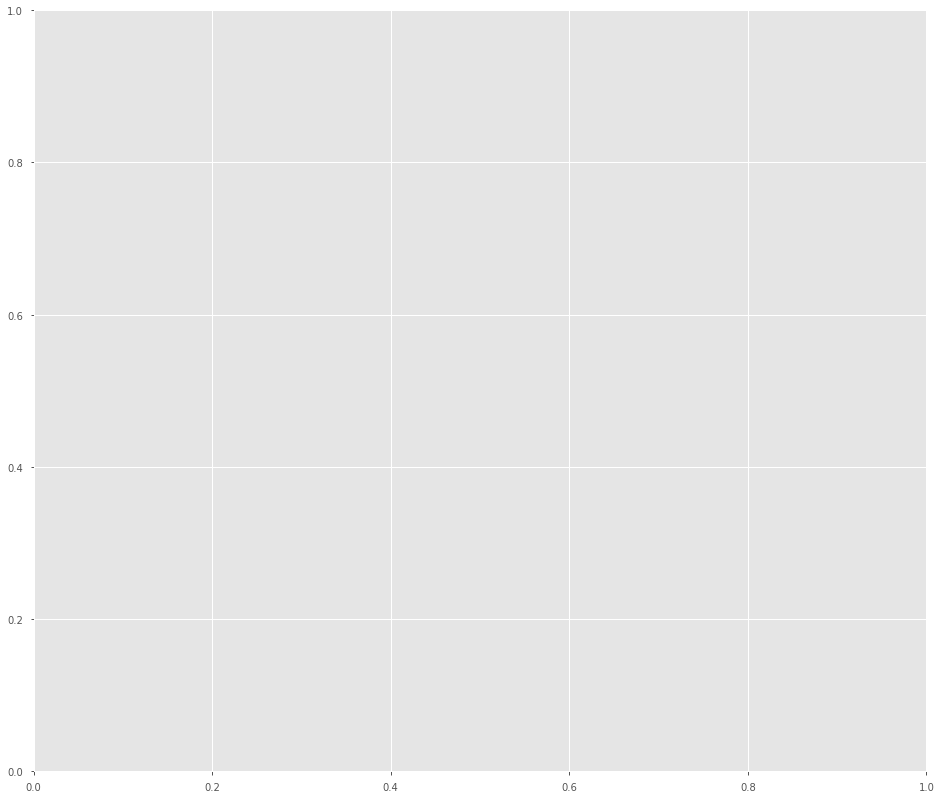

In [59]:
_, ax = plt.subplots(figsize=(16, 14))

In [40]:
def plot_importance_save_img(bst, plot_param=None):
    xgb.plot_importance(bst, ax=ax, max_num_features=50)

In [16]:
plt.figure(figsize=(16, 12))
xgb.plot_importance(best_model, max_num_features=50)

NameError: name 'best_model' is not defined

<Figure size 1152x864 with 0 Axes>

In [63]:
plt.show()

In [41]:
plot_importance_save_img(best_model, plot_param)

In [70]:
plt.savefig('./figure.png')

<Figure size 432x288 with 0 Axes>

In [84]:
# print(gs.best_params_)
# print(gs.cv_results_['mean_test_score'])
# print(gs.best_estimator_)

In [68]:
y_preds

[array([0.45434386, 0.45434386, 0.45434386, ..., 0.45434386, 0.45434386,
        0.45434386], dtype=float32),
 array([0.4548826, 0.4548826, 0.4548826, ..., 0.4548826, 0.4548826,
        0.4548826], dtype=float32),
 array([0.01246002, 0.01387715, 0.03219134, ..., 0.01586309, 0.01938164,
        0.02412187], dtype=float32),
 array([0.01246002, 0.01387715, 0.03219134, ..., 0.01586309, 0.01938164,
        0.02412187], dtype=float32),
 array([0.01246002, 0.01387715, 0.03219134, ..., 0.01586309, 0.01938164,
        0.02412187], dtype=float32)]

In [85]:
y_sub = sum(y_preds) / len(y_preds)
sample_submission['isFraud'] = y_sub

In [86]:
import datetime 

In [96]:
score = str(score)
score

'0.9198920000000002'

In [88]:
path = './data/input/'
print(path + 'sub_{0:%Y-%m-%d_%H:%M:%S}_{1}.csv'.format(datetime.datetime.now(), score[:8]))

./data/input/sub_2019-09-02_00:52:33_[0.92317.csv


In [89]:
sample_submission.to_csv('sub_{0:%Y-%m-%d_%H:%M:%S}_{1}.csv'.format(datetime.datetime.now(), score[:8]))

In [94]:
# best = gs.best_estimator_

In [95]:
# sum(gs.cv_results_['mean_test_score']) / len(gs.cv_results_['mean_test_score'])